In [2]:
from api_key import API_KEY
from mistralai.client import MistralClient
from sklearn.metrics.pairwise import euclidean_distances
import polars as pl
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

In [3]:

client = MistralClient(api_key=API_KEY)

embeddings_batch_response = client.embeddings(
    model="mistral-embed",
    input=["Embed this sentence.", "As well as this one."],
)


In [4]:
len(embeddings_batch_response.data[0].embedding)

1024

In [5]:
def get_text_embedding(input):
    embeddings_batch_response = client.embeddings(
        model="mistral-embed",
        input=input
    )
    return embeddings_batch_response.data[0].embedding

In [6]:
sentences = [
    "A home without a cat — and a well-fed, well-petted and properly revered cat — may be a perfect home, perhaps, but how can it prove title?",
    "I think books are like people, in the sense that they'll turn up in your life when you most need them"
]
embeddings = [get_text_embedding(t) for t in sentences]

reference_sentence = "Books are mirrors: You only see in them what you already have inside you"
reference_embedding = get_text_embedding(reference_sentence)

for t, e in zip(sentences, embeddings):
    distance = euclidean_distances([e], [reference_embedding])
    print(t, distance)

A home without a cat — and a well-fed, well-petted and properly revered cat — may be a perfect home, perhaps, but how can it prove title? [[0.80094257]]
I think books are like people, in the sense that they'll turn up in your life when you most need them [[0.56210557]]


In [7]:
sentences = (
    pl.read_csv(
    source=r"C:\Users\faune\Downloads\FinancialPhraseBank-v1.0\FinancialPhraseBank-v1.0\Sentences_AllAgree.txt",
    separator="\t",
    ignore_errors=True,
    has_header=False
    )
    .rename({'column_1': 'sentences'})
    .select(pl.col('sentences').str.split('@').list.to_struct()).unnest('sentences')
    .rename({'field_0': 'sentences', 'field_1':'label'})
    .drop_nulls()
)


In [8]:
sentences_list = sentences.select('sentences').to_series().to_list()

In [9]:
# get_embeddings_by_chunks(sentences_list, 50)

In [10]:
def get_embeddings_by_chunks(data, chunk_size):
    chunks = [data[x : x + chunk_size] for x in range(0, len(data), chunk_size)]
    embeddings_response = [
        client.embeddings(model="mistral-embed", input=c) for c in chunks
    ]
    return [d.embedding for e in embeddings_response for d in e.data]

sentences = sentences.with_columns(pl.Series(name='embeddings', values= get_embeddings_by_chunks(sentences.select('sentences').to_series().to_list(), 50)))
sentences.head()

sentences,label,embeddings
str,str,list[f64]
"""According to G…","""neutral""","[-0.028625, 0.000851, … 0.015053]"
"""For the last q…","""positive""","[-0.037231, -0.005157, … 0.019821]"
"""In the third q…","""positive""","[-0.047729, 0.002062, … 0.01889]"
"""Operating prof…","""positive""","[-0.049011, 0.009354, … 0.014511]"
"""Operating prof…","""positive""","[-0.05014, 0.00362, … 0.013725]"


In [11]:
sentences

sentences,label,embeddings
str,str,list[f64]
"""According to G…","""neutral""","[-0.028625, 0.000851, … 0.015053]"
"""For the last q…","""positive""","[-0.037231, -0.005157, … 0.019821]"
"""In the third q…","""positive""","[-0.047729, 0.002062, … 0.01889]"
"""Operating prof…","""positive""","[-0.049011, 0.009354, … 0.014511]"
"""Operating prof…","""positive""","[-0.05014, 0.00362, … 0.013725]"
…,…,…
"""Operating resu…","""negative""","[-0.040619, 0.008965, … 0.00491]"
"""HELSINKI Thoms…","""negative""","[-0.045532, 0.024551, … -0.020355]"
"""LONDON MarketW…","""negative""","[-0.006428, 0.050018, … 0.001163]"


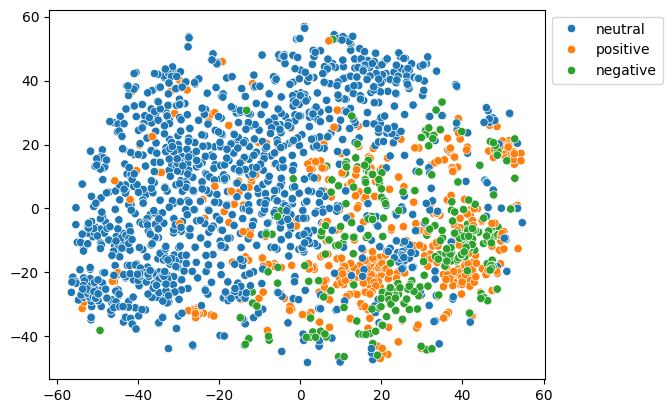

In [12]:
tsne = TSNE(n_components=2, random_state=0).fit_transform(np.array(sentences.select('embeddings').to_series().to_list()))
ax = sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=np.array(sentences.select('label').to_series().to_list()))
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

In [13]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3, max_iter=1000)
model.fit(sentences.select('embeddings').to_series().to_list())
sentences = sentences.with_columns(pl.Series(name='cluster', values=model.labels_))
# print(*df[df.cluster==23].text.head(3), sep='\n\n')

In [14]:
# print(*sentences.filter(pl.col('cluster').eq(23)).head(3), sep='\n\n')

In [15]:
sentences.filter(pl.col('cluster').eq(1))

sentences,label,embeddings,cluster
str,str,list[f64],i32
"""For the last q…","""positive""","[-0.037231, -0.005157, … 0.019821]",1
"""In the third q…","""positive""","[-0.047729, 0.002062, … 0.01889]",1
"""Operating prof…","""positive""","[-0.049011, 0.009354, … 0.014511]",1
"""Operating prof…","""positive""","[-0.05014, 0.00362, … 0.013725]",1
"""Finnish Talent…","""positive""","[-0.064209, -0.003508, … 0.017761]",1
…,…,…,…
"""Comparable ope…","""negative""","[-0.040771, 0.002354, … 0.004673]",1
"""In the Baltic …","""negative""","[-0.048737, 0.020721, … 0.00308]",1
"""Operating prof…","""negative""","[-0.025162, 0.012306, … 0.017838]",1


<Axes: xlabel='cluster', ylabel='Count'>

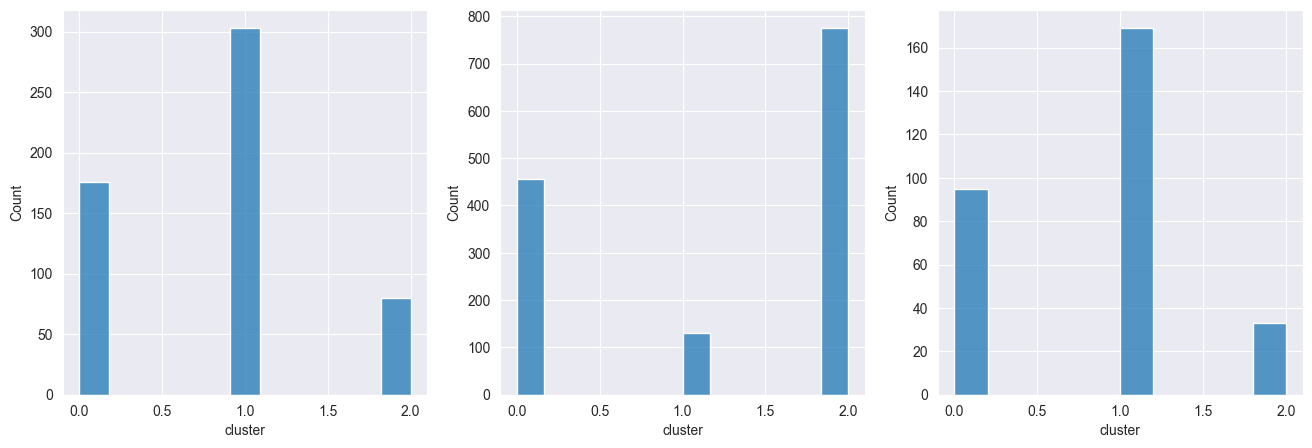

In [85]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches(16,5)
sns.histplot(sentences.filter(pl.col('label').eq('positive')).to_pandas(), x='cluster', ax=axes[0])
sns.histplot(sentences.filter(pl.col('label').eq('neutral')).to_pandas(), x='cluster', ax=axes[1])
sns.histplot(sentences.filter(pl.col('label').eq('negative')).to_pandas(), x='cluster', ax=axes[2])

In [82]:
def get_pieplot(label: str, frame: pl.DataFrame,axs: list, ax: int) -> None:
    frame_pie = frame.filter(pl.col('label').eq(label)).group_by('cluster').agg(pl.col('label').count()).select(pl.col('cluster').cast(pl.String), pl.col('label'))
    category_colors = {'0': '#A0DDFF', '1': '#758ECD', '2': '#C1CEFE'}
    labels = category_colors.keys()
    colors = [category_colors[label] for label in labels]
    axs[ax].pie(
        x= frame_pie.select('label').to_series().to_pandas(), 
        labels= frame_pie.select('cluster').to_series().to_pandas(), 
        autopct='%1.1f%%', 
        colors= colors,
        startangle=90)
    axs[ax].axis('equal')
    axs[ax].set_title(f"{label.title()} labeled sentences by cluster")
    return None

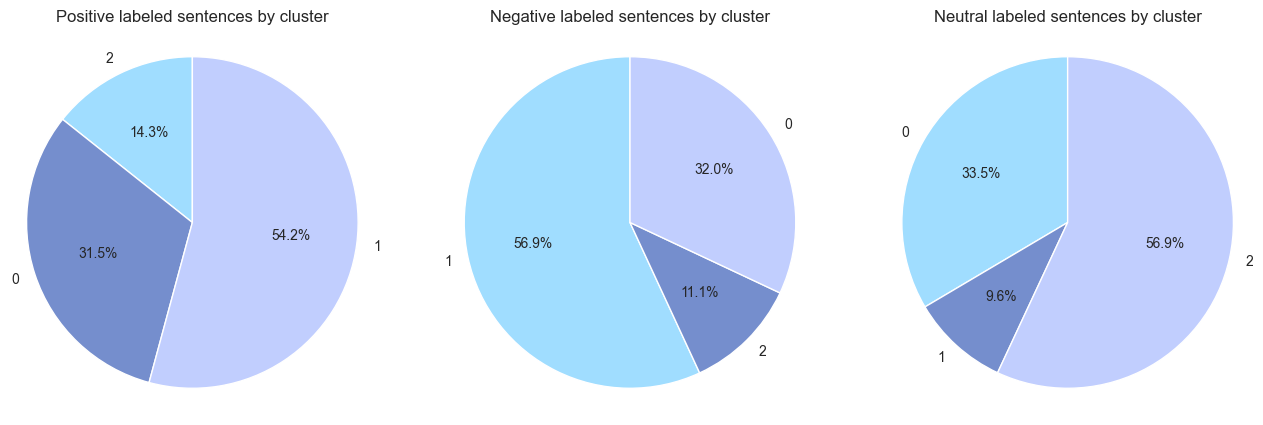

In [83]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
get_pieplot(label='positive', frame=sentences, ax=0, axs=axs)
get_pieplot(label='negative', frame=sentences, ax=1, axs=axs)
get_pieplot(label='neutral', frame=sentences, ax=2, axs=axs)

plt.show()

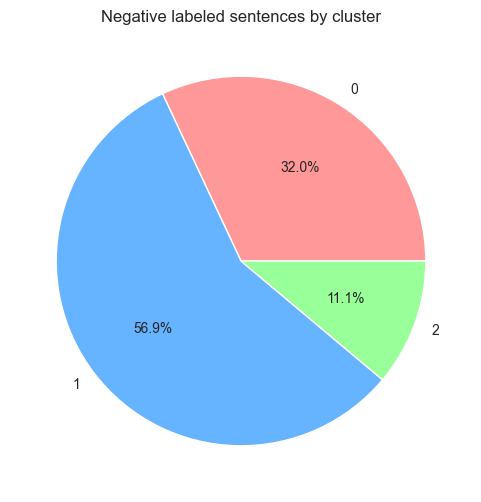

In [35]:
get_pieplot(label='negative', frame=sentences)

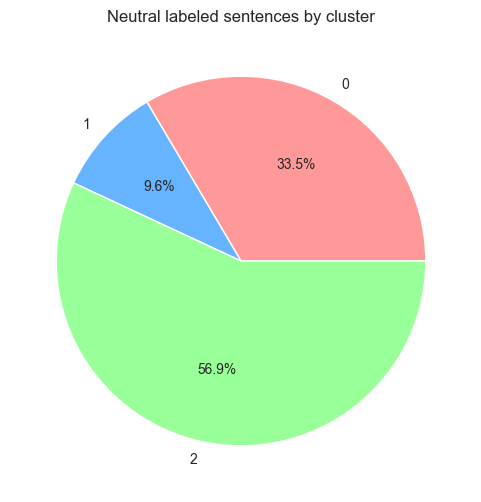

In [36]:
get_pieplot(label='neutral', frame=sentences)

In [22]:
frame_pie = sentences.filter(pl.col('label').eq('positive')).group_by('cluster').agg(pl.col('label').count())

([<matplotlib.patches.Wedge at 0x22797b97510>,
 [Text(0.990682248088597, 0.47806765559084197, '2'),
  Text(-0.34344445792924305, 1.0450100020180135, '0'),
  Text(-0.14485564564519565, -1.090420488584433, '1')],
 [Text(0.5403721353210528, 0.26076417577682287, '14.3%'),
  Text(-0.187333340688678, 0.5700054556461891, '31.5%'),
  Text(-0.07901217035192488, -0.5947748119551453, '54.2%')])

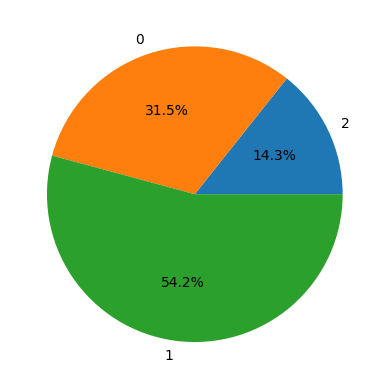

In [26]:
plt.pie(x=frame_pie.select('label').to_series().to_pandas(), labels=frame_pie.select('cluster').to_series().to_pandas(), autopct='%1.1f%%')